In [142]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.offline import plot
import seaborn as sns
import matplotlib.pyplot as plt

from pca import pca

import warnings
warnings.filterwarnings('ignore')


# Background
The data used for final assignment for supervised learning is the Intermediate dataset. The goal of this assignment is to use unsupervised machine learnign methods to find patterns or clusters in the input data.Two datatsets were used in this assignment. One conatins the gene expression data of subjects wth lungs cancer and other contains the information such as gender, tumor size, location of cancer etc.Both data sets contain 89 subjects or samples.
Since no labeeling or classes are used for making the model in the assignment , unsupervised machine learning models are implemented.

## 1.Data loading and inspection
This part shows reading the data into dataframe and some analysis on dataframe such as df. describe, df.info etc.

In [143]:
path='C:\\Dilton G\Hanze_University\\S2_Q4  Hanze\\Data_Science3_Prediction\\Unsupervised learning'
file='\Lung3.metadata.xls'
# Reading the lungs data
lungs_df=pd.read_excel(path + file,)
# Reading the gene expresison data
gene_df=pd.read_csv(path+'\GSE58661_series_matrix.txt',skiprows=62,sep='\t',)

In [144]:
print(lungs_df.isnull().sum())
print(gene_df.isnull().sum())

sample.name                                       0
title                                             0
CEL.file                                          0
source.location                                   0
organism                                          0
characteristics.tag.gender                        0
characteristics.tag.histology                     0
characteristics.tag.tumor.size.maximumdiameter    1
characteristics.tag.stage.primary.tumor           0
characteristics.tag.stage.nodes                   0
characteristics.tag.stage.mets                    0
characteristics.tag.primaryVSmets                 0
characteristics.tag.grade                         0
molecule tested                                   0
label                                             0
platform                                          0
dtype: int64
ID_REF        0
GSM1416528    1
GSM1416529    1
GSM1416530    1
GSM1416531    1
             ..
GSM1416612    1
GSM1416613    1
GSM1416614    1
GSM1416615 

There is one missing column in gene data set and one nan value in tumour size column. The one missing column is removed in the subsequent analysis.

In [145]:
print(gene_df.shape)
print(lungs_df.shape)


print(gene_df.info())


(60608, 90)
(89, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60608 entries, 0 to 60607
Data columns (total 90 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID_REF      60608 non-null  object 
 1   GSM1416528  60607 non-null  float64
 2   GSM1416529  60607 non-null  float64
 3   GSM1416530  60607 non-null  float64
 4   GSM1416531  60607 non-null  float64
 5   GSM1416532  60607 non-null  float64
 6   GSM1416533  60607 non-null  float64
 7   GSM1416534  60607 non-null  float64
 8   GSM1416535  60607 non-null  float64
 9   GSM1416536  60607 non-null  float64
 10  GSM1416537  60607 non-null  float64
 11  GSM1416538  60607 non-null  float64
 12  GSM1416539  60607 non-null  float64
 13  GSM1416540  60607 non-null  float64
 14  GSM1416541  60607 non-null  float64
 15  GSM1416542  60607 non-null  float64
 16  GSM1416543  60607 non-null  float64
 17  GSM1416544  60607 non-null  float64
 18  GSM1416545  60607 non-null  float64
 19  GSM1

In [146]:
gene_df.tail()

,ID_REF,GSM1416528,GSM1416529,GSM1416530,GSM1416531,GSM1416532,GSM1416533,GSM1416534,GSM1416535,GSM1416536,...,GSM1416607,GSM1416608,GSM1416609,GSM1416610,GSM1416611,GSM1416612,GSM1416613,GSM1416614,GSM1416615,GSM1416616
60603,merck2-Z70222_a_at,6.892053,5.513603,6.112918,6.276813,7.041829,7.560786,7.446324,7.821045,7.465401,...,7.028523,6.229570,7.543618,7.518894,6.541189,6.493021,7.952822,6.978308,7.460604,7.519374
60604,merck2-Z70608_x_at,1.777216,1.940099,1.753519,1.889742,1.686633,1.988420,1.723665,2.029634,1.986343,...,3.246869,1.910438,1.910438,2.054199,1.730252,1.924313,1.783032,1.371800,1.811532,2.444065
60605,merck2-Z72499_a_at,9.031084,9.527973,9.515653,9.383670,9.464486,9.558521,9.651009,9.479608,9.417764,...,9.349558,9.377011,9.379870,9.398441,9.269749,9.223950,9.481911,9.632680,9.313734,9.527973
60606,merck2-Z75331_a_at,7.284069,6.985508,6.556233,7.293852,6.244336,5.562862,6.933691,6.389961,6.860160,...,6.622611,6.406113,6.642260,6.292372,6.618915,5.817185,7.487134,7.410402,6.396247,5.605377
60607,!series_matrix_table_end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The gene dataframe is transposed and has nan entries in the last row. Hence some preprocesisng of gene datafreame is needed. 
The following part transposes the gene dataframe and drop the last row to get equal samples with lungs dataset

In [147]:
#transposing the gene df
transpose_df=gene_df.T
#setting the index to subjects
transpose_df.set_axis(list(transpose_df.loc['ID_REF']),axis=1,inplace=True)
#dropping the last column
transpose_df.drop('ID_REF',inplace=True)
transpose_df.tail()
transpose_df=transpose_df.iloc[:,:-1]
#chnaging data type to number
transpose_df = transpose_df.apply(pd.to_numeric)
   


Some columns of the lungs dataframe are renamed and the data type is changed.

In [148]:
print(lungs_df.info())
lungs_df.isnull().sum()
print(lungs_df.describe())
lungs_df.rename(columns={"characteristics.tag.gender":'Gender','characteristics.tag.histology':'cancer',' characteristics.tag.tumor.size.maximumdiameter':'Tumor_size'},inplace=True)
lungs_df[['Gender','cancer','source.location']]=lungs_df[['Gender','cancer','source.location']].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 16 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   sample.name                                     89 non-null     object 
 1   title                                           89 non-null     object 
 2   CEL.file                                        89 non-null     object 
 3   source.location                                 89 non-null     object 
 4   organism                                        89 non-null     object 
 5   characteristics.tag.gender                      89 non-null     object 
 6   characteristics.tag.histology                   89 non-null     object 
 7   characteristics.tag.tumor.size.maximumdiameter  88 non-null     float64
 8   characteristics.tag.stage.primary.tumor         89 non-null     object 
 9   characteristics.tag.stage.nodes              

In [149]:
lungs_df['cancer'].value_counts()

Squamous Cell Carcinoma, NOS                                            33
Adenocarcinoma, NOS                                                     25
Non-Small Cell                                                           7
Adenocarcinoma, Bronchiolo-alveolar Features                             4
Adenocarcinoma, Papillary, NOS                                           4
Adenocarcinoma, Acinar Type                                              3
Solid Type And Acinar                                                    2
Adenocarcinoma With Papillary Features                                   2
Adenocarcinoma With Mucinous Features                                    1
Squamous Cell Carcinoma, Other (Specify)endobronchial                    1
Squamous Cell Carcinoma, Other (Specify) with adeno features             1
Carcinoma, Large Cell, Neuroendocrine                                    1
Papillary Type AND      Adenocarcinoma, Bronchiolo-alveolar Features     1
Non-Small Cell, Pleomorph

As seen from above squamous and adenocarcinoma types are repeating. Hence I regrouped to three categories namely Squamous,Adenocarcinoma and Others to  make the labels more clear. The below function does the regrouping.

In [150]:
def cancer(x):
    if 'Squamous' in x:
        return 'Squamous'
    elif 'Adenocarcinoma' in x:
        return 'Adenocarcinoma'
    else:
        return 'Others'
lungs_df['cancer_type']=lungs_df['cancer'].apply(lambda x:cancer(x)).astype('category')

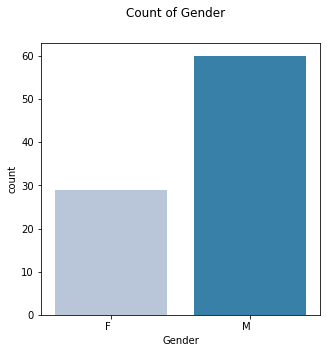

In [151]:
# Countplot of gender

plt.figure(figsize = (5, 5))
ax = sns.countplot(x=lungs_df['Gender'], palette = 'PuBu')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha = "right")
plt.suptitle("Count of Gender")
plt.show()


## 2.Data preparation

In [152]:
transpose_df.skew(axis=0)

AFFX-BioB-3_at        3.614279
AFFX-BioB-5_at        3.658087
AFFX-BioB-M_at        3.627996
AFFX-BioC-3_at        2.575990
AFFX-BioC-5_at        2.390309
                        ...   
merck2-Z48633_s_at    0.206106
merck2-Z70222_a_at   -0.387533
merck2-Z70608_x_at    1.364450
merck2-Z72499_a_at    0.862061
merck2-Z75331_a_at    0.040207
Length: 60607, dtype: float64

Data has some skewness. Skweness is expected as we have a small number of samples(89 samples).So removing skewed columns will lead to loss of information.Hence  Standardization(zscore) is implemented to reduce the skewness.

In [153]:
centered=(transpose_df-transpose_df.mean(axis=0))/transpose_df.std(axis=0)


## 3.Model Building
This section implements three algorithms. First dimensionality reduction followed by k means clustering. For dimensionality redution PCA and tSNE to reduce the dimesnionlaity. After reducing the dimensions, k-means clustering is done on principal and tSNE components.


In [154]:
from sklearn.decomposition import PCA

X = centered
#Building the compoents till you get 90 percent variance.

model = pca(n_components=0.90)

# Fit transform
results = model.fit_transform(centered)



[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [60607] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [66] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [60607] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[66]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


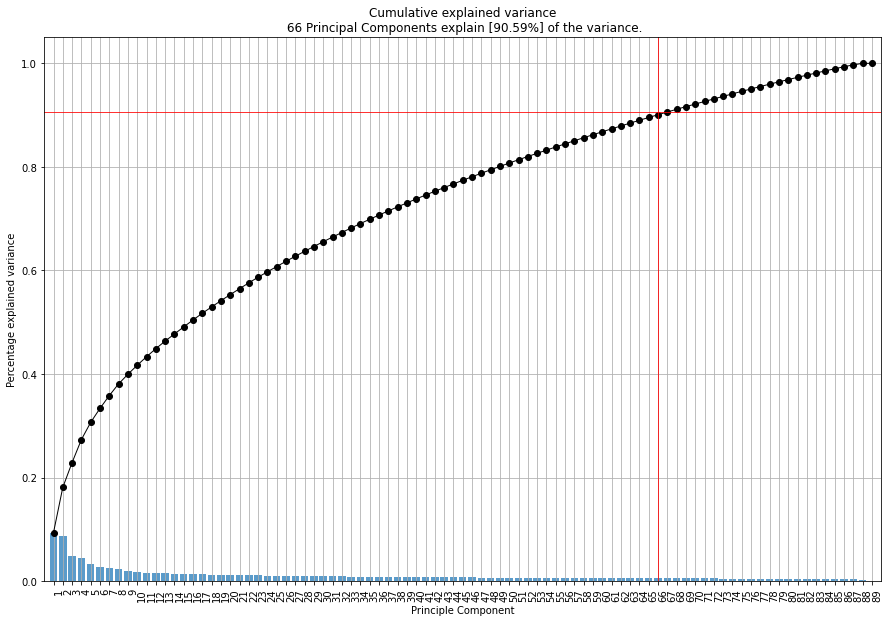

<Figure size 432x288 with 0 Axes>

In [155]:
# Plotting the elbow plot to see the cumulative variance.
fig, ax = model.plot()



To capture 90 percent variance needs 66 components . This shows that features done have big difference in their variances. This was expected as all features are from the same domain(gene expression) and less samples.

The next code cells plots PC1 and PC2, then PC2 and PC3 to see any separation. For labelling the data points I used Gender and Cancer type information

In [165]:
projections=results['PC'].reset_index(drop=True)
#source.location
fig1 = px.scatter(projections,x=projections['PC1'], y=projections['PC2'], color=lungs_df['cancer_type'],symbol=lungs_df['Gender'],title='Scatter plot PC1 and PC2')#characteristics.tag.tumor.size.maximumdiameter
fig1.show()

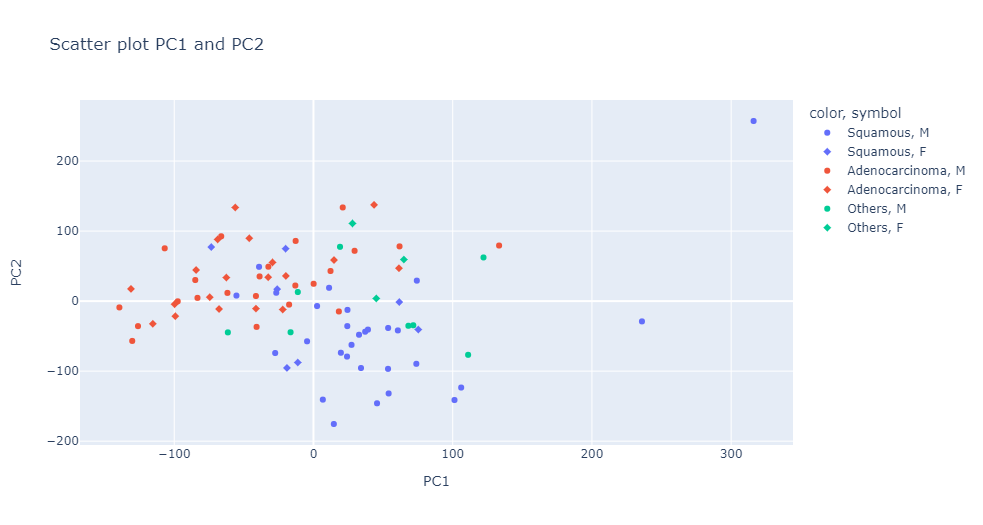

In [157]:
fig1 = px.scatter(projections,x=projections['PC2'], y=projections['PC3'], color=lungs_df['cancer_type'],symbol=lungs_df['Gender'],title='Scatter plot PC2 and PC3')#characteristics.tag.tumor.size.maximumdiameter
fig1.show()

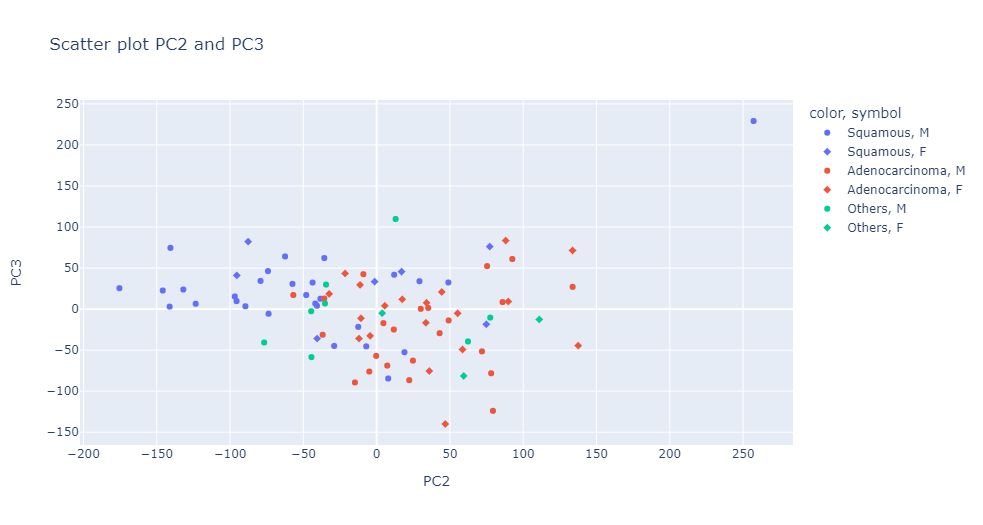

Principal componet analysis doesnt show good seperation. This was expected as alomost 66 principal componenst were needed to explain 90 percent of variance.

For the following sections tSNE and Kmeans clustering are implemented. Since tSNE is computationally complex algorithm, it is recommended to use tSNE with an dimensionality reduction algoritm.i.e. PCA

The next cell executes tSNE on raw dataset.

In [158]:
#tSNE on raw dataset
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1, perplexity=40, n_iter= 4000,learning_rate='auto')
Y = tsne.fit_transform(X)

Y.shape


[t-SNE] Computing 88 nearest neighbors...
[t-SNE] Indexed 89 samples in 0.066s...
[t-SNE] Computed neighbors for 89 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 89 / 89
[t-SNE] Mean sigma: 107.882138
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.088818
[t-SNE] KL divergence after 800 iterations: 0.236016


(89, 2)

In [159]:
fig1 = px.scatter(Y,x=Y[:,0], y=Y[:,1], color=lungs_df['cancer_type'],title='tSNE on raw dataset')#symbol=lungs_df['Gender'],title='TSNe components')#characteristics.tag.tumor.size.maximumdiameter
fig1.show()

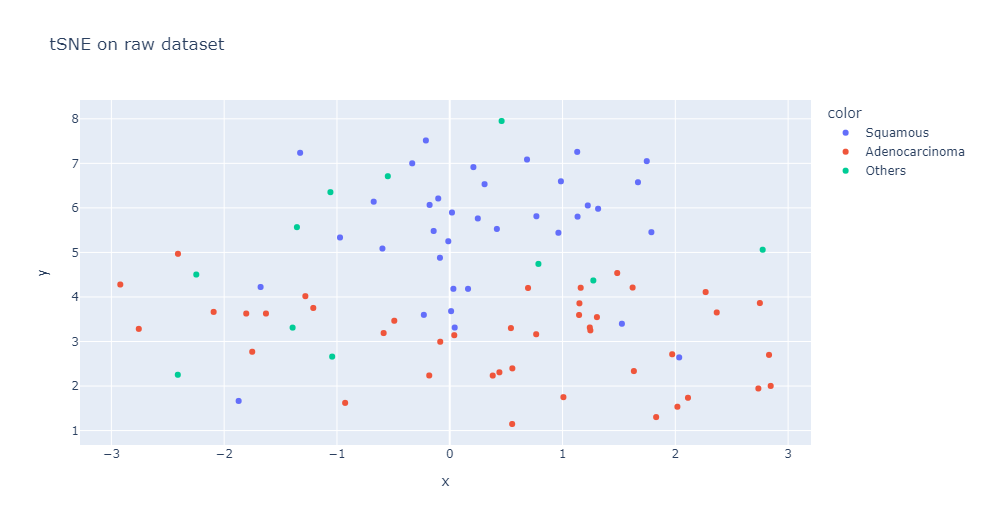

There is seperation between Adenocarcinoma and Squamous but the seperation is hindered by 'others' cancer type.Clustering is not good but this is probably due to less samples.




Following cell executes tSNE on PCA components.

In [160]:
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2,kernel='rbf')
pc = pca.fit_transform(X)

In [161]:
#initiate instance
X_embedded = TSNE(n_components=2, learning_rate='auto', random_state = 42, init='random')
#fit 
X_embedded = X_embedded.fit_transform(pc)

X_embedded.shape


(89, 2)

Since the cancer types are grouped into three categories number of clusters in kmeans is used as three.

In [162]:
from sklearn.cluster import KMeans
#Y=X_embedded
def compare(Y):
    """Function to compare K means clustering on tSNE,PCA and raw dataset
    Arguments:
    Y: Dimensionality reduced data using direct tSNE or tSNE with PCA
    
    
    OuTputs:
    Plots comparing k means clustering on actual """

    kmns = KMeans(n_clusters=3, init='k-means++')
    kY = kmns.fit_predict(X)
    fig=plt.figure(figsize=(18, 10),)


    plt.subplot(221)
    plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
    plt.title('k-means on X')
    plt.axis('off')



    # K-means on tSNE results
    kmns = KMeans(n_clusters=3, init='k-means++')
    kY = kmns.fit_predict(Y)

    plt.subplot(222)
    plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.5)
    plt.title('k-means on tSNE')
    plt.axis('off')


    # K-means on PC 1 - 2
    kmns = KMeans(n_clusters=3, init='k-means++')
    kY = kmns.fit_predict(projections.iloc[:,0:2])

    plt.subplot(223)
    plt.scatter(Y[:,0],Y[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.5)
    plt.title('k-means on PC1-2')
    plt.axis('off')


    plt.subplot(224)

    sns.scatterplot(Y[:,0],Y[:,1], lungs_df['cancer_type'])
    plt.title('Actual clusters')
    plt.axis('off')
    plt.show()


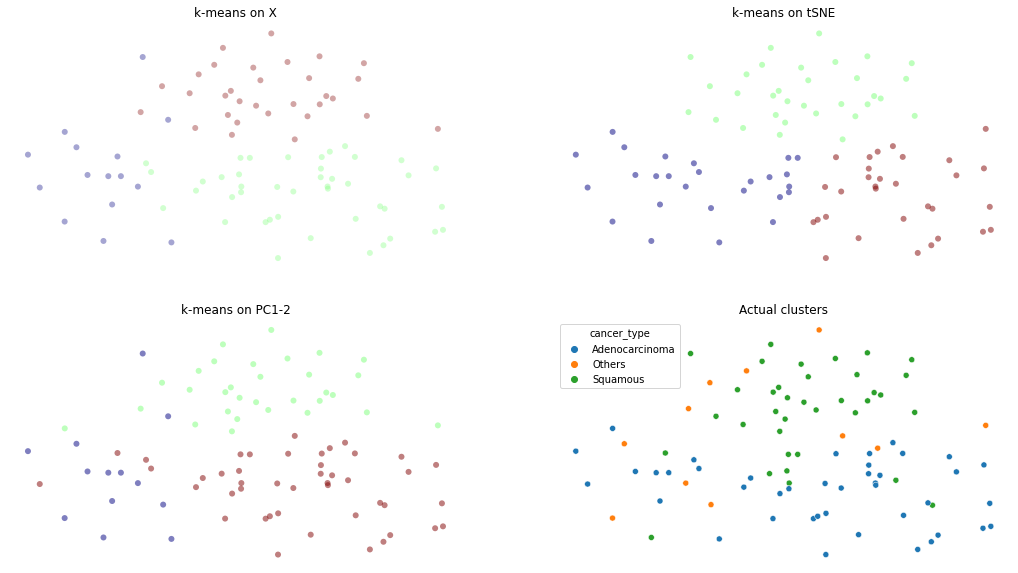

In [163]:
#Here Y is dimensionally reduced data using only tSNE
compare(Y)

K means on tSNE shows a good clustering of three cancer types. Kmeans on principal component 1 and principal components shows also some clustering.

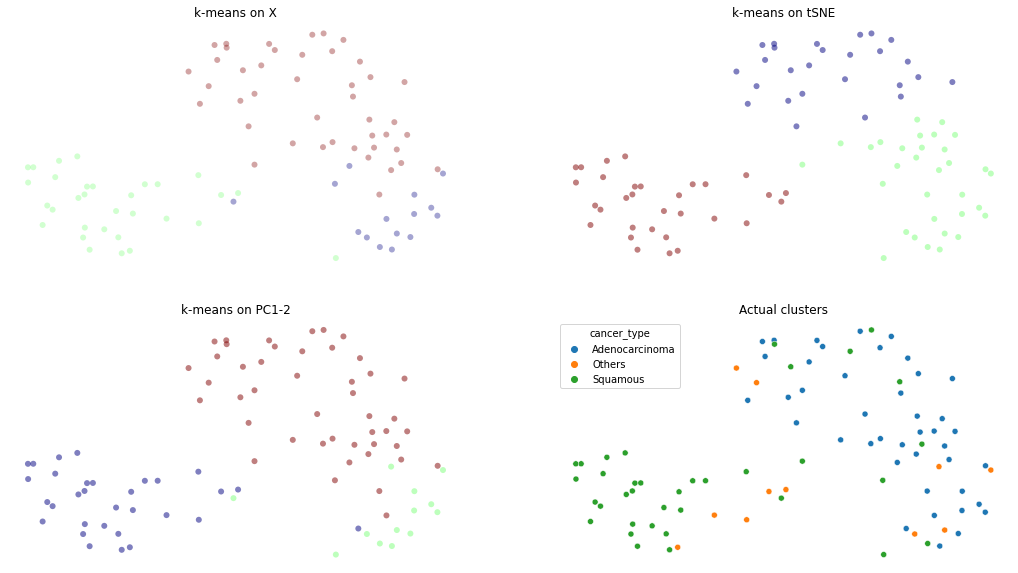

In [164]:
compare(X_embedded)

Here Kmeans clustering is done on on dimensionally reduced data using PCA and then tSNE.Again Kmeans on tSNE shows improved clustering compared to the above case where no PCA was performed prior to tSNE model building.



#  Discussion and Conclusion:
The assignment tried to build unspupervised  models to find gene expression data of lung cancer patients.PCA analsyis alone didnt cluster good.This is probably becuase lack of variance diffrence between the features(columns). 
tSNE is a non linear dimensionality reduction technique that find clusters by preserving small pairwise distances whereas PCA preserves large pairwise distances. tSNE being a non linear technique works best for gene expression data as this data has data points close to each other. This distances are taken into account by tSNE unlike PCA where it try to maximize variance within
data. Becuase tSNE performs good in this case, algorithms like DBSCAN can also show good clustering as it find clusters in densed data points .i.e. points which are close to each other.
For this assignment an combination of multiple method showed best clustering. .i.e initiallly data is dimensionally reduced using PCA and then data is used for making tSNE model. The output of the tSNE model is then used with K means clustering to get the clusters.